In [20]:
import fourtenmodule

fourtenmodule.hellohello()

heloo


In [21]:
import numpy as np
import matplotlib.pyplot as plt
#import scikit_learn as sklearn

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler



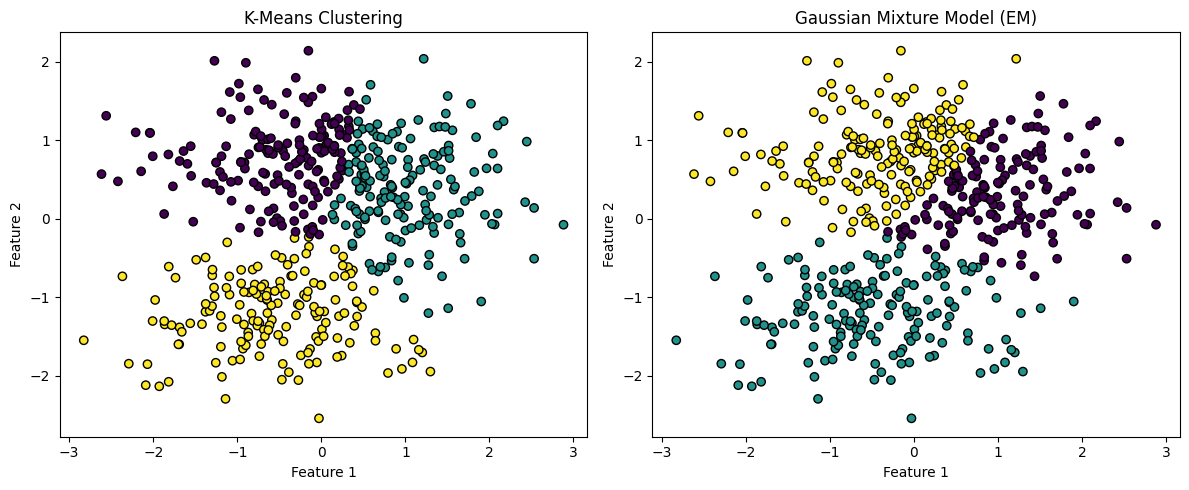

K-Means Inertia (Sum of squared distances): 357.12
GMM Log-Likelihood: -1335.78


In [22]:

# Generate synthetic customer segmentation data
np.random.seed(410)
X, _ = make_blobs(n_samples=500, centers=3, cluster_std=1.2, random_state=410)
X = StandardScaler().fit_transform(X)

# Fit K-Means model
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Fit Gaussian Mixture Model (EM algorithm)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k')
ax[0].set_title("K-Means Clustering")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")

ax[1].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', edgecolors='k')
ax[1].set_title("Gaussian Mixture Model (EM)")
ax[1].set_xlabel("Feature 1")
ax[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Compare log-likelihood scores
print(f"K-Means Inertia (Sum of squared distances): {kmeans.inertia_:.2f}")
print(f"GMM Log-Likelihood: {gmm.score(X) * len(X):.2f}")

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from hmmlearn import hmm
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from scipy.optimize import minimize

# Generate synthetic dataset
np.random.seed(42)
X = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[-2, -2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[2, -2], scale=0.5, size=(100, 2))
])

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Apply GMM using Expectation-Maximization
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Apply HMM for clustering sequential data
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", random_state=42)
hmm_model.fit(X)
hmm_labels = hmm_model.predict(X)

# Newton-like method for optimizing GMM parameters
def neg_log_likelihood(params):
    means = params[:6].reshape(3,2)  # Adjust shape for 3 clusters in 2D
    covars = params[6:].reshape(3,2,2)  # Reshape covariances correctly

    gmm_custom = GaussianMixture(n_components=3)
    gmm_custom.means_ = means
    gmm_custom.covariances_ = covars
    gmm_custom.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covars))  # Ensure correct precision matrices

    return -gmm_custom.score(X)


initial_params = np.hstack([gmm.means_.ravel(), gmm.covariances_.ravel()])
def grad_neg_log_likelihood(params, epsilon=1e-5):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params_step = params.copy()
        params_step[i] += epsilon  # Small perturbation
        grad[i] = (neg_log_likelihood(params_step) - neg_log_likelihood(params)) / epsilon
    return grad

res = minimize(neg_log_likelihood, initial_params, method='Newton-CG', jac=grad_neg_log_likelihood)

# Simple Variational Autoencoder (VAE) for generative modeling
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae = VAE(input_dim=2, hidden_dim=10, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
data_tensor = torch.tensor(X, dtype=torch.float32)

for epoch in range(100):
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(data_tensor)
    loss = vae_loss(recon_x, data_tensor, mu, logvar)
    loss.backward()
    optimizer.step()

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
axes[0].set_title("K-Means Clustering")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm_labels, palette="coolwarm", ax=axes[1])
axes[1].set_title("GMM Clustering")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=hmm_labels, palette="Set1", ax=axes[2])
axes[2].set_title("HMM Clustering")
axes[3].plot(range(100), loss.detach().numpy(), label="VAE Loss")
axes[3].set_title("VAE Training Loss")
plt.show()



AttributeError: 'GaussianMixture' object has no attribute 'weights_'

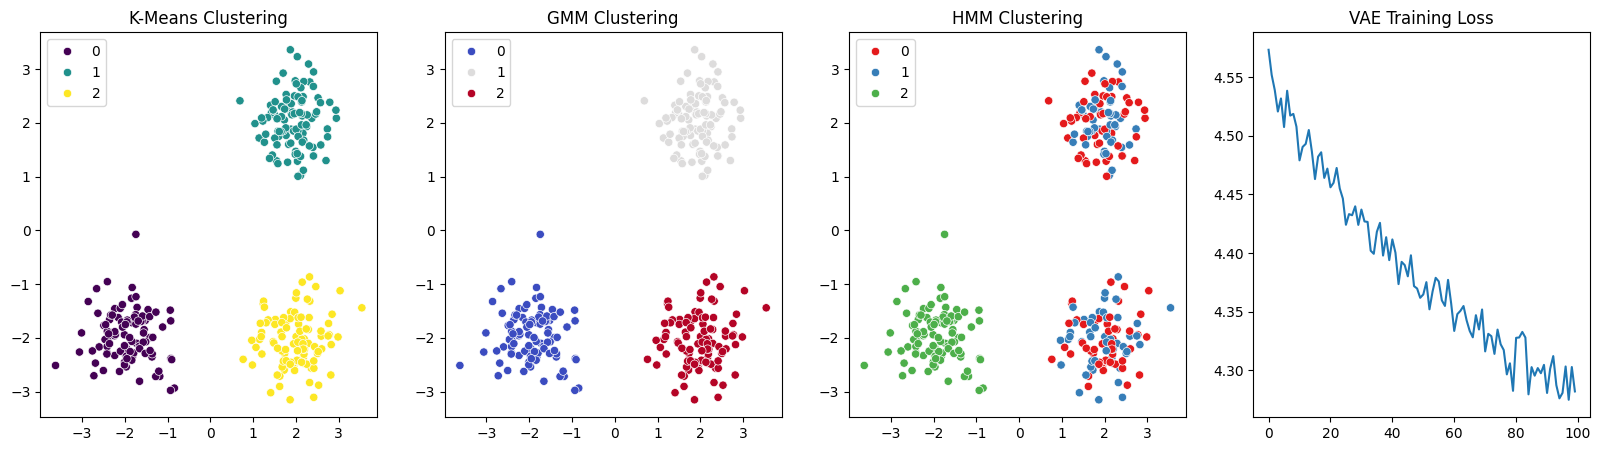

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from hmmlearn import hmm
from scipy.optimize import minimize

# Generate synthetic dataset
np.random.seed(42)
X = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[-2, -2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[2, -2], scale=0.5, size=(100, 2))
])

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

# Apply GMM using Expectation-Maximization
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Apply HMM for clustering sequential data
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", random_state=42)
time_series = np.arange(len(X)).reshape(-1, 1)  # Add a time index
hmm_model.fit(np.hstack([X, time_series]))  # Fit using time index
hmm_labels = hmm_model.predict(np.hstack([X, time_series]))

# Newton-like optimization for GMM parameters
def neg_log_likelihood(params):
    means = params[:6].reshape(3, 2)
    covars = params[6:].reshape(3, 2, 2)
    for i in range(3):
        covars[i] = covars[i] @ covars[i].T + np.eye(2) * 1e-6  # Ensure positive semi-definiteness
    gmm_custom = GaussianMixture(n_components=3, covariance_type="full")
    gmm_custom.means_init = means
    gmm_custom.fit(X)  # Refit model
    return -gmm_custom.score(X)

initial_params = np.hstack([gmm.means_.ravel(), gmm.covariances_.ravel()])
res = minimize(neg_log_likelihood, initial_params, method='BFGS')

# Variational Autoencoder (VAE) Class
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae = VAE(input_dim=2, hidden_dim=10, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
data_tensor = torch.tensor(X, dtype=torch.float32)

# Train VAE
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(data_tensor)
    loss = vae_loss(recon_x, data_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
axes[0].set_title("K-Means Clustering")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=gmm_labels, palette="coolwarm", ax=axes[1])
axes[1].set_title("GMM Clustering")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=hmm_labels, palette="Set1", ax=axes[2])
axes[2].set_title("HMM Clustering")
axes[3].plot(range(100), losses, label="VAE Loss")
axes[3].set_title("VAE Training Loss")
plt.show()



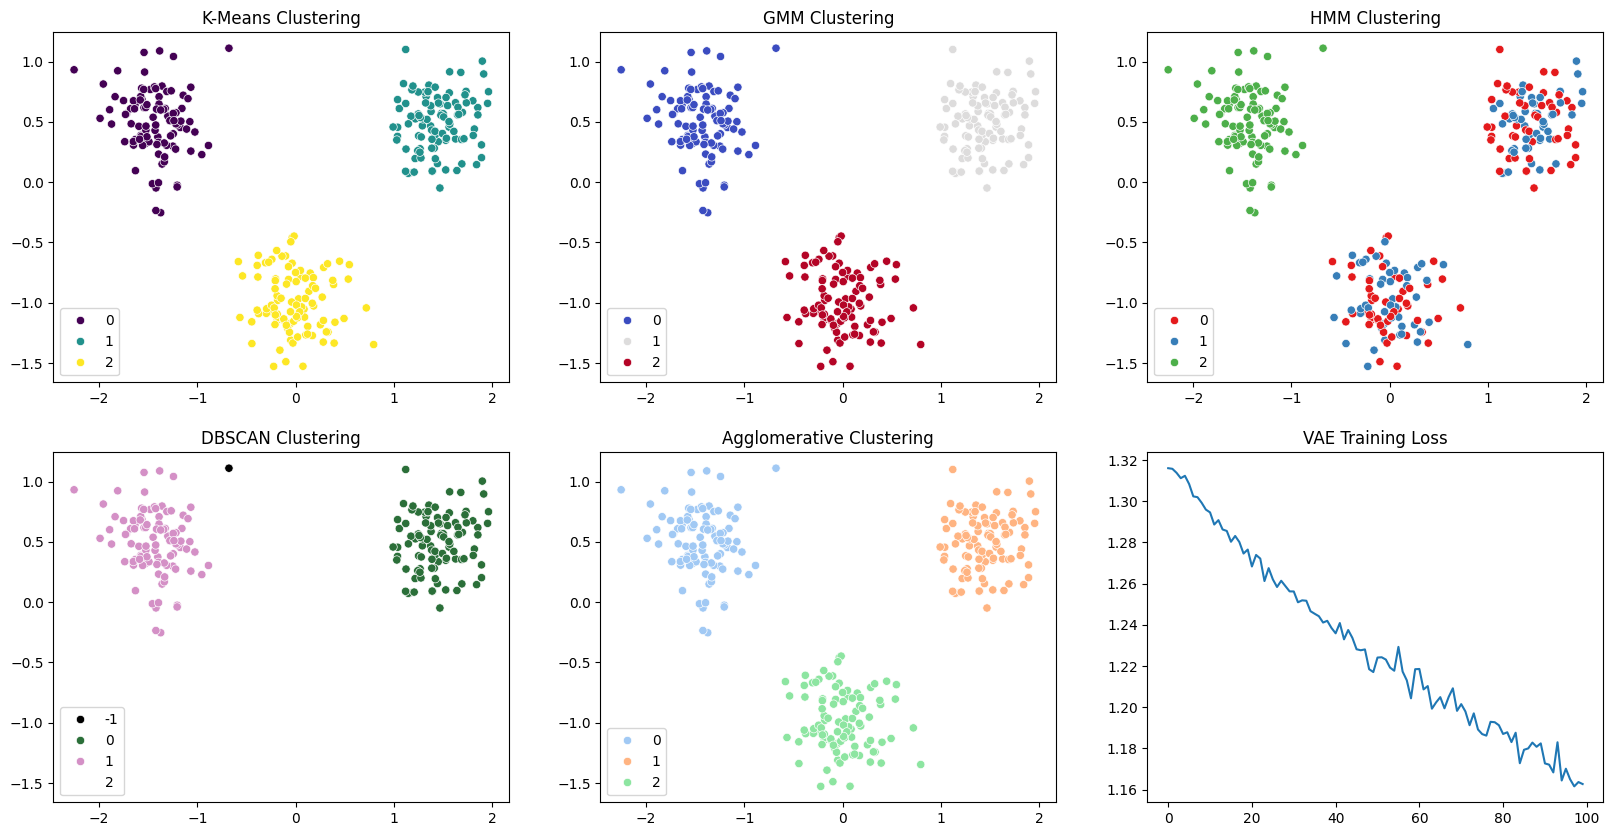

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from hmmlearn import hmm
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
np.random.seed(42)
X = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[-2, -2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[2, -2], scale=0.5, size=(100, 2))
])

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply clustering methods
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", random_state=42)
time_series = np.arange(len(X)).reshape(-1, 1)
hmm_model.fit(np.hstack([X_scaled, time_series]))
hmm_labels = hmm_model.predict(np.hstack([X_scaled, time_series]))

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(X_scaled)

# Newton-like optimization for GMM parameters
def neg_log_likelihood(params):
    means = params[:6].reshape(3, 2)
    covars = params[6:].reshape(3, 2, 2)
    for i in range(3):
        covars[i] = covars[i] @ covars[i].T + np.eye(2) * 1e-6
    gmm_custom = GaussianMixture(n_components=3, covariance_type="full")
    gmm_custom.means_init = means
    gmm_custom.fit(X_scaled)
    return -gmm_custom.score(X_scaled)

initial_params = np.hstack([gmm.means_.ravel(), gmm.covariances_.ravel()])
res = minimize(neg_log_likelihood, initial_params, method='BFGS')

# Variational Autoencoder (VAE) Class
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae = VAE(input_dim=2, hidden_dim=10, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
data_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Train VAE
losses = []
for epoch in range(100):
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(data_tensor)
    loss = vae_loss(recon_x, data_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("K-Means Clustering")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("GMM Clustering")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hmm_labels, palette="Set1", ax=axes[0, 2])
axes[0, 2].set_title("HMM Clustering")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette="cubehelix", ax=axes[1, 0])
axes[1, 0].set_title("DBSCAN Clustering")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agg_labels, palette="pastel", ax=axes[1, 1])
axes[1, 1].set_title("Agglomerative Clustering")
axes[1, 2].plot(range(100), losses, label="VAE Loss")
axes[1, 2].set_title("VAE Training Loss")
plt.show()


In [2]:
import numpy as np

# Given data
Q = np.array([[6, -1],
              [-1, 2]])

b = np.array([25, 8])

# Initial point
x0 = np.array([25, 5])

# Compute initial gradient
r0 = Q @ x0 - b

# Initialize search direction as negative gradient
p0 = -r0

# Store points for x1, x2, x3
points = [x0]

# Conjugate Gradient iterations
for i in range(3):
    alpha = (r0 @ r0) / (p0 @ Q @ p0)
    print("alpha", alpha)
    x_new = x0 + alpha * p0
    
    r_new = r0 + alpha * (Q @ p0)
    beta = (r_new @ r_new) / (r0 @ r0)
    p_new = -r_new + beta * p0

    # Update values for next iteration
    x0, r0, p0 = x_new, r_new, p_new
    points.append(x0)

points


alpha 0.16056486480672846
alpha 0.5661829629945377
alpha 0.16035948506193826


[array([25,  5]),
 array([5.73221622, 8.69299189]),
 array([5.27272727, 6.63636364]),
 array([5.27272727, 6.63636364])]